# Deep learning from scratch: homework 4, Kaiyuan Hou, 2974802

### General instructions

Complete the exericses listed below in this Jupyter notebook - leaving all of your code in Python cells in the notebook itself.

### When submitting this homework:

**Make sure you have put your name at the top of this file**

**This is the only file you must submit** 
    
**Make sure all output is present in your notebook prior to submission**

**Do not zip your files when uploading to canvas**

In [11]:
# imports necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from PIL import Image

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

-----------

#### <span style="color:#a50e3e;">Exercise 1. </span> ZCA sphereing, K-means clustering, and natural image patches

In this Exercise you will use the K-means algorithm (see [Section 11.5 of the course notes](https://jermwatt.github.io/mlrefined/blog_posts/11_Linear_unsupervised_learning/11_5_K_means_clustering.html)) to cluster a set of natural image patches.  

First, you need to complete the `extract_patches` module below. This module will extract a total of `number_of_pathes` randomly-positioned patches of size `patch_size` from megapixel images listed in `image_list`. When coding `extract_patches` make sure to exclude flat or nearly flat patches, i.e., those wherein the standard deviation of pixel values falls below $0.1$.

In [12]:
# Hint: you can use the line below to convert an image to a numpy array  
# image_as_numpy_array = np.array(Image.open(path_to_image).convert('L'))

In [13]:
def extract_patches(image_list, number_of_patches, patch_size):
    import random

    imgs = []
    for path in image_list:
        imgs.append(np.array(Image.open(path).convert('L')))

    patches = np.empty([patch_size * patch_size, number_of_patches], int)

    for i in range(number_of_patches):
        img = imgs[(int)(i * len(image_list) / number_of_patches)]
        while True:
            u = random.randint(0, img.shape[0] - patch_size)
            v = random.randint(0, img.shape[0] - patch_size)
            patch = img[u:u + patch_size, v: v + patch_size].reshape([patch_size * patch_size])
            if np.std(patch) >= 0.1:
                break
        patches[:, i] = patch

    return patches

Once you have coded up `extract_patches`, activate the following cell to extract $100000$ image patches, each of size $12 \times 12$, from the four images given below.

In [14]:
image_1 = 'images/bean.jpg'
image_2 = 'images/dog.jpg'
image_3 = 'images/flyer.jpg'
image_4 = 'images/Trey_Matt.png'

image_list = [image_1, image_2, image_3, image_4]
number_of_patches = 100000
patch_size = 12
              
patches = extract_patches(image_list, number_of_patches, patch_size)   

Notice, `patches` must be a matrix of size $144 \times 100000$ where each column is a flattened/vectorized $12 \times 12$ patch. The cell below plots the first $100$ patches in `patches` (Note: each column has to be reshaped back into a square before plotting).

<IPython.core.display.Javascript object>


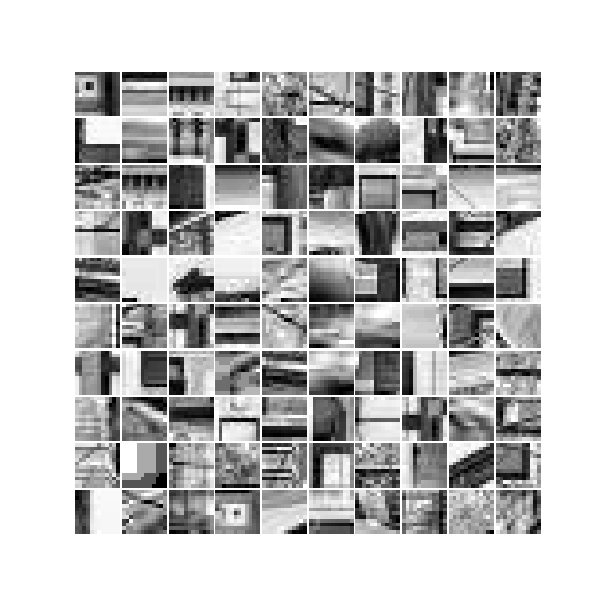

In [15]:
def show_images(X):
    '''
    Function for plotting input images, stacked in columns of input X.
    '''
    # plotting mechanism taken from excellent answer from stack overflow: https://stackoverflow.com/questions/20057260/how-to-remove-gaps-between-subplots-in-matplotlib
    plt.figure(figsize = (6,6))
    gs1 = gridspec.GridSpec(10, 10)
    gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 
    
    # shape of square version of image
    square_shape = int((X.shape[0])**(0.5))

    for i in range(min(100,X.shape[1])):
        # plot image in panel
        ax = plt.subplot(gs1[i])
        im = ax.imshow(np.reshape(X[:,i],(square_shape,square_shape)),cmap = 'gray')

        # clean up panel
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    plt.show()
    
# Plot the first 100 patches 
show_images(patches)

<figure><img src="Figures/sample_patches.png" width="50%" height="auto"></figure>

Now perform ZCA sphereing to normalize `patches`. To do this, you may use and adjust the PCA sphereing code provided in [Section 11.3 of the course notes](https://jermwatt.github.io/mlrefined/blog_posts/11_Linear_unsupervised_learning/11_3_PCA_sphereing.html). Remember, ZCA sphereing differs from PCA sphereing by one simple step (See Figure below and compare with Figure 1 in [Section 11.3 of the course notes](https://jermwatt.github.io/mlrefined/blog_posts/11_Linear_unsupervised_learning/11_3_PCA_sphereing.html)).    

<figure><img src="Figures/ZCA_diagram.png"></figure>

In [16]:
# YOUR CODE GOES HERE
# patches_ZCA_normalized = ...
# compute eigendecomposition of data covariance matrix for PCA transformation
def PCA(x,**kwargs):
    # regularization parameter for numerical stability
    lam = 10**(-7)
    if 'lam' in kwargs:
        lam = kwargs['lam']

    # create the correlation matrix
    P = float(x.shape[1])
    Cov = 1/P*np.dot(x,x.T) + lam*np.eye(x.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    d,V = np.linalg.eigh(Cov)
    return d,V

# ZCA-sphereing - use ZCA to normalize input features
def ZCA_sphereing(x,**kwargs):
    # Step 1: mean-center the data
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_centered = x - x_means

    # Step 2: compute pca transform on mean-centered data
    d,V = PCA(x_centered,**kwargs)

    # Step 3: divide off standard deviation of each (transformed) input, 
    # which are equal to the returned eigenvalues in 'd'.  
    stds = (d[:,np.newaxis])**(0.5)
    normalizer = lambda data: np.dot(V, np.dot(V.T,data - x_means)/stds)

    # create inverse normalizer
    inverse_normalizer = lambda data: np.dot(V,np.dot(V.T, data)*stds) + x_means

    # return normalizer 
    return normalizer,inverse_normalizer

normalizer, inverse_normalizer = ZCA_sphereing(patches)

patches_ZCA_normalized = normalizer(patches)

Activate the cell below to plot the first $100$ patches in `patches_ZCA_normalized` - this is the matrix containing ZCA-normalized patches.

<IPython.core.display.Javascript object>


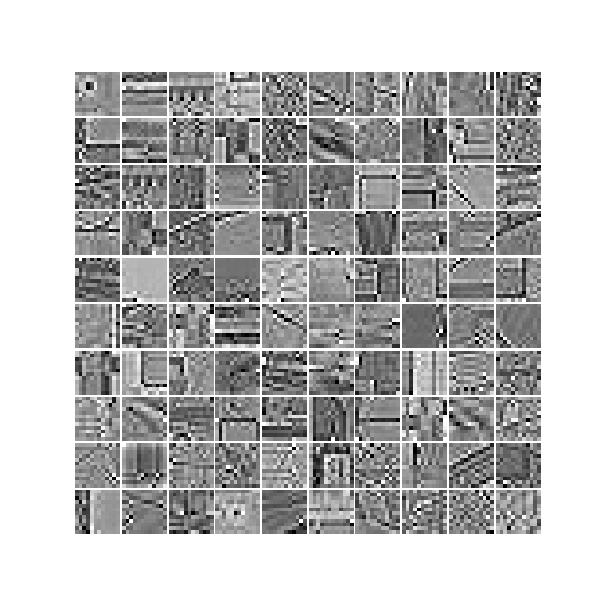

In [17]:
show_images(patches_ZCA_normalized)

<figure><img src="Figures/sample_ZCA.png" width="50%" height="auto"></figure>

To perform clustering on ZCA normalized patches we make use of `scikit-learn`'s efficient implementation of the K-means algorithm. Activating the cell below will run K-means for a maximum of $2000$ iterations with learned centroids stored in the matrix `centroids`.       

In [18]:
# perform K-means clustering
from sklearn.cluster import KMeans

# number of clusters
num_clusters = 100 

clusterer = KMeans(n_clusters=num_clusters, max_iter = 2000, n_init = 1)

# fit the algorithm to our dataset
clusterer.fit(patches_ZCA_normalized.T)

# extract cluster centroids
centroids = clusterer.cluster_centers_.T

Each centroid iself can be viewed as a patch when reshaped into a $12 \times 12$ matrix. Python cell below plots all these centroids.   

<IPython.core.display.Javascript object>


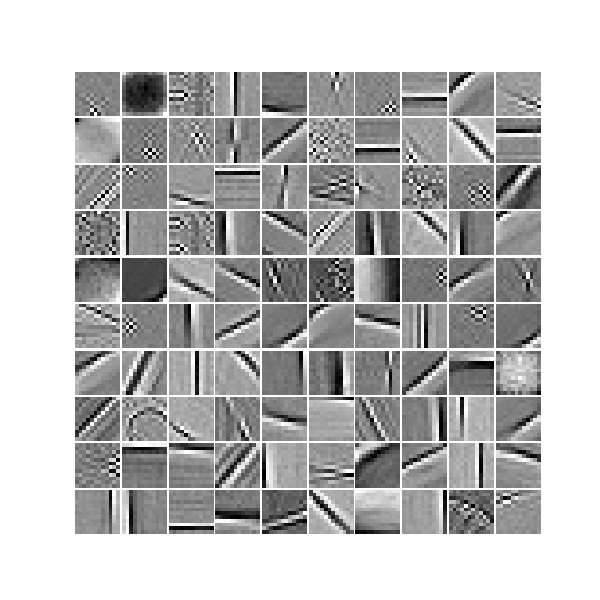

In [19]:
show_images(centroids)

<figure><img src="Figures/sample_centroids.png" width="50%" height="auto"></figure>

A majority of these learned centroids look like edge-detectors, e.g., the centroid highlighted in the Figure below representing a horizontal edge detector. 

<figure><img src="Figures/edge_detector.png" width="70%" height="auto"></figure>

Can you explain why learned centroids resemble edge detectors of varying width and orientation? Hint: see [Section 14.2.1 of the course notes](https://jermwatt.github.io/mlrefined/blog_posts/14_Convolutional_networks/14_2_Edge_histogram_based_features.html).    

##### YOUR ANSWER GOES HERE

"Distinguishing information in a natural image is largely contained in the relatively small number of edges in an image."

From what it states, it is likely that patches containing the edge has larger variance than patches that does not. After  normalizetion, patches without an edge tends to becomes more uniform. As a reuslt, there are more groups within patches that contains edges than patches without and edge. Thus, we can see many centroid from groups that contains edges in similar width and orientation that looks like an edge dector.





Finally, run K-means again, this time on the data stored in `patches` and plot the learned centroids.       

<IPython.core.display.Javascript object>


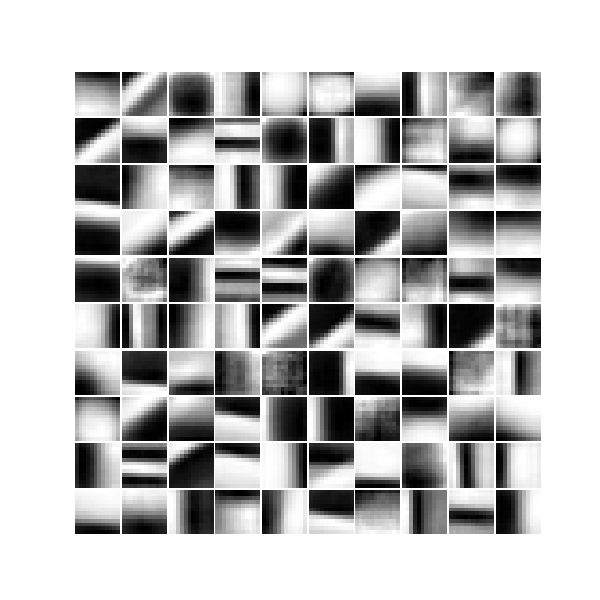

In [20]:
clusterer = KMeans(n_clusters=num_clusters, max_iter = 2000, n_init = 1)

# fit the algorithm to our dataset
clusterer.fit(patches.T)

# extract cluster centroids
centroids = clusterer.cluster_centers_.T

show_images(centroids)

<figure><img src="Figures/sample_unnormalized.png" width="50%" height="auto"></figure>

As you can see, without normalization, K-means algorithm is incapable of learning edge detector-like patches from the data.  

------------

#### <span style="color:#a50e3e;">Exercise 2. </span> Counting the number of tunable weights in a simple CNN 

Suppose you want to perform two-class cassification using convolutional neural networks on a training dataset consisting of $50,000$ face and non-face images, each of size $32 \times 32$. Your CNN has a single convolutional layer followed by a three (hidden) layer MLP as shown in the Figure below.      

<figure><img src="Figures/pipe_1.png"></figure>

In this Exercise you will find the total number of weights to be learned using this CNN architecture having the following specifications:

- Number of convolutional kernels: $10$
- Size of each convolutional kernel: $3\times 3$
- Pooling window size: $4\times 4$
- Pooling stride = 2 
- Number of units/neurons per layer of MLP: 5

##### YOUR ANSWER GOES HERE
No padding:

    Feature map size: (32 - 3 + 1) * (32 - 3 + 1) = 30 * 30
    Pool layer output: ((30 - 4) / 2 + 1) * ((30 - 4) / 2 + 1) = 14 * 14
    Feature transform output: 14 * 14 * 10 = 1960
    Filter weight: 3 * 3 * 10 = 90
    MPL Layer 1 weight: 1960 * 5 = 9800
    MPL Layer 1 weight: 5 * 5 = 25
    MPL Layer 1 weight: 5 * 5 = 25
    MPL Bias: 5 * 3 = 15
    Total weight include bias: 9800 + 90 + 25 + 25 + 15 = 9955

Padding 1 0 on boundary:

    Feature map size: 32 * 32
    Pool layer output: ((32 - 4) / 2 + 1) * ((34 - 4) / 2 + 1) = 15 * 15
    Feature transform output: 15 * 15 * 10 = 2250
    Filter weight: 3 * 3 * 10 = 90
    MPL Layer 1 weight: 2250 * 5 = 11250
    MPL Layer 1 weight: 5 * 5 = 25
    MPL Layer 1 weight: 5 * 5 = 25
    MPL Bias: 5 * 3 = 15
    Total weight include bias: 11250 + 90 + 25 + 25 + 15 = 11405

Padding 2 0 on boundary:

    Feature map size: 34 * 34
    Pool layer output: ((34 - 4) / 2 + 1) * ((34 - 4) / 2 + 1) = 15 * 15
    Feature transform output: 15 * 15 * 10 = 2250
    Filter weight: 3 * 3 * 10 = 90
    MPL Layer 1 weight: 2250 * 5 = 11250
    MPL Layer 1 weight: 5 * 5 = 25
    MPL Layer 1 weight: 5 * 5 = 25
    MPL Bias: 5 * 3 = 15
    Total weight include bias: 11250 + 90 + 25 + 25 + 15 = 11405
